## Atari Breakout Q-Learning

##### Allow memory growth for tensorflow, Windows work around

In [1]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

##### Verify GPU availability

from tensorflow.python.client import device_lib  
print(device_lib.list_local_devices())  
from keras import backend as K  
print(K.tensorflow_backend._get_available_gpus())  

#### Training

In [2]:
from ai_image_preprocess import preprocess

def step(env, action, state):
    next_frame_1, reward_1, done_1, _ = env.step(action)
    next_frame_2, reward_2, done_2, _ = env.step(action)
    next_state = util.update_state_arr(state, preprocess(next_frame_1), preprocess(next_frame_2))
    return (next_state, reward_1 + reward_2, done_1 or done_2)

In [3]:
import ai_display as display
import ai_util as util
from ai_logger import Logger
import time

def train(env, agent, n_episodes, model_name="model", save_interval=100):
    logger = Logger(10, "    Episode | #frames | score | avg_step_time")
    
    for episode in range(n_episodes):
        
        frame = env.reset()
        state = util.create_state_arr(preprocess(frame))
        score = 0
        
        start_time = time.time()
        for t in range(1000):
            #display.show_state(state[3], env.spec.id, t, score)

            action = agent.act(state)

            next_state, reward, done = step(env, action, state)
            
            agent.remember(state, action, reward, next_state, done)
            
            state = next_state
            score += reward
            
            agent.replay(batch_size=32)
            
            if done: 
                logger.log("{:>5}/{} | {:>7} | {:>5} | {:.5f}"
                           .format(episode+1, n_episodes, t, score, (time.time() - start_time)/t))
                break
                
        if episode % save_interval == 0:
            agent.save_model(model_name)
        
    agent.save_model(model_name)
        

#### Main

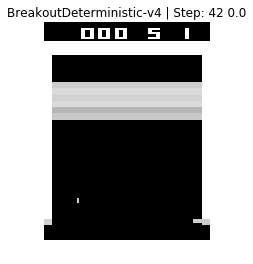

In [ ]:
from ai_agent import Agent
import gym

env = gym.make("BreakoutDeterministic-v4")
n_actions = env.action_space.n
state_shape = (105, 80, 4)

agent = Agent(state_shape, n_actions, epsilon=0.6)

model_name = "new-model"
#agent.new_model()
agent.load_model(model_name) 
train(env, agent, n_episodes=10000, model_name=model_name, save_interval=10)
